In [1]:
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

In [2]:
os.chdir('/Users/spencergibson/Desktop')

In [41]:
### Checking what the first day looks like to get an idea

pd.read_parquet('qr_takehome/QR_TAKEHOME_20220104.csv.parquet', engine='pyarrow')

,time,sym,exch,Q1,Q2,X1,X10,X100,X101,X102,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
0,35101000,SPX,cme,1.00,1.00,0.690880,0.411336,-0.931992,-0.795623,0.323744,...,0.306629,0.202722,0.614319,-1.480256,-0.692901,0.271547,0.363600,0.418456,-3.641376,-8.869885
1,35102000,SPX,cme,1.00,1.00,0.012410,0.490745,-1.107317,-0.879008,0.085624,...,0.068109,-0.032056,-0.168017,-1.680816,-0.796525,0.035415,0.127641,-0.355632,-4.161573,-9.855279
2,35103000,SPX,cme,1.00,1.00,-0.562206,0.222636,-0.562283,-0.434286,-0.058180,...,-0.074431,-0.169338,-0.307943,-1.148484,-0.361814,-0.109707,-0.015605,-0.484356,-5.201696,-13.037217
3,35104000,SPX,cme,1.00,1.00,0.611162,0.895365,-0.606271,-0.565673,0.892154,...,0.866210,0.778337,0.720537,-1.206177,-0.506229,0.861149,0.959148,0.531968,-8.581905,-16.222198
4,35105000,SPX,cme,1.00,1.00,0.263148,0.699131,-0.831379,-0.823448,0.463870,...,0.433482,0.244060,0.095464,-1.450160,-0.782949,0.443536,0.433311,-0.090943,-8.322713,-17.588816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,57596000,SPX,cme,0.21,0.12,0.034295,-1.192947,NaN,-1.040731,NaN,...,NaN,-1.256609,-1.085969,NaN,-1.060124,NaN,-2.028626,-0.924568,1.045342,1.920757
22496,57597000,SPX,cme,0.21,0.12,-1.037593,-1.264724,NaN,0.614270,NaN,...,NaN,-0.436382,-0.488310,NaN,0.609001,NaN,-1.223317,-0.319625,0.522644,0.384092
22497,57598000,SPX,cme,0.21,0.12,-1.459643,-0.746727,NaN,1.082658,NaN,...,NaN,0.293667,-0.416507,NaN,1.102270,NaN,-0.482725,-0.242319,0.000000,-0.768096
22498,57599000,SPX,cme,0.21,0.12,-1.270207,-0.797160,NaN,1.116927,NaN,...,NaN,0.342586,-0.166629,NaN,1.162199,NaN,-0.421563,0.007323,-0.522589,-1.075302


In [3]:
''''    
Add each parquet file to a pandas dataframe and include a date column for identification purposes
This is for predicting Y1 only
'''

dfs_y2 = []

for file in os.listdir('qr_takehome'):
    if file[0] != 'Q':
        continue
    curr_data = pd.read_parquet(f'qr_takehome/{file}', engine='pyarrow')
    curr_data['day'] = file 
    dfs_y2.append(curr_data)

data_y2 = pd.concat(dfs_y2, ignore_index=True)

In [47]:
len(dfs_y2)

298

In [48]:
data_y2.shape

(6705000, 383)

In [4]:
data_y2 = data_y2[data_y2['Q2'] > .999]

In [50]:
data_y2.shape

(6404259, 383)

In [51]:
print(data_y2.columns)
data_y2.dtypes

Index(['time', 'sym', 'exch', 'Q1', 'Q2', 'X1', 'X10', 'X100', 'X101', 'X102',
       ...
       'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y1', 'Y2', 'day'],
      dtype='object', length=383)


time      int64
sym      object
exch     object
Q1      float32
Q2      float32
         ...   
X98     float32
X99     float32
Y1      float32
Y2      float32
day      object
Length: 383, dtype: object

In [52]:
### Looking at the number of rows with missing values. This is 3%. 

num_rows_with_nans = data_y2.isna().any(axis=1).sum()
num_rows_with_9999 = (data_y2 == 999999).any().sum()
(num_rows_with_nans + num_rows_with_9999) / data_y2.shape[0]

0.02546164981772286

In [53]:
### Checking the proportion of columns that have more than 10% missing. All columns have less than 3% missing
nan_proportion = data_y2.isna().mean()

nan_nonzero_proportion = nan_proportion[nan_proportion > .04]
print(nan_nonzero_proportion)

Series([], dtype: float64)


In [5]:
### Removing any row with missing values

data_y2_cleaned = data_y2.dropna()
data_y2_cleaned.shape[0] / data_y2.shape[0]

0.9745383501822772

In [59]:
np.isnan(data_y2_cleaned["Y2"]).sum()

0

In [60]:
### Saving the cleaned data for easier access 

cleaned_data_file_path =  'qr_takehome/Cleaned Data/Y2 Calibration/data_y2_cleaned.parquet'
data_y2_cleaned.to_parquet(cleaned_data_file_path)

In [4]:
### Loading cleaned data in case of crash 
# Define the directory where the files are saved
save_dir = 'qr_takehome/Cleaned Data/Y2 Calibration/'

# Load the .parquet files into their corresponding variables
data_y2_cleaned = pd.read_parquet(os.path.join(save_dir, 'data_y2_cleaned.parquet'))

In [5]:
group = data_y2_cleaned.groupby('day')

In [62]:
# Checking if the average y2 or Y2 values change substantially over time

groups = data_y2_cleaned.groupby('day')
Y2_vals = []
time_cutoff_list = [11, 12, 13, 14, 15, 16]
time_cutoff_dict_Y2 = {11:[], 12:[], 13:[], 14:[], 15:[], 16:[]}
for name, group in groups:
    prev = 35101000
    Y2_vals.append(group["Y2"].mean())
    # Get the average y2 up to time X across days
    for time_cutoff in time_cutoff_list:
        avg_Y2 = group[(group["time"] >= prev) &  
                       (group["time"] <= time_cutoff * 60 * 60 * 1000)]
        if avg_Y2.shape[0] == 0: # If there are no entries don't take the mean
            print(time_cutoff, name)
            continue 
        time_cutoff_dict_Y2[time_cutoff].append(avg_Y2["y2"].mean())
        prev = time_cutoff * 60 * 60 * 1000 + 1


15 QR_TAKEHOME_20230106.csv.parquet


In [63]:
# Fitting a linear model to the data to check for increasing trends

from scipy.stats import linregress
Y2_times = [i for i in range(len(Y2_vals))]
slope_Y2, intercept_Y2, *_ = linregress(Y2_times, Y2_vals)

In [64]:
len(Y2_vals)

298

In [ ]:
# Things to consider: 
# Is there a significant change in Y value over time? 
# Is there a significant change in Y value across time periods during the day?

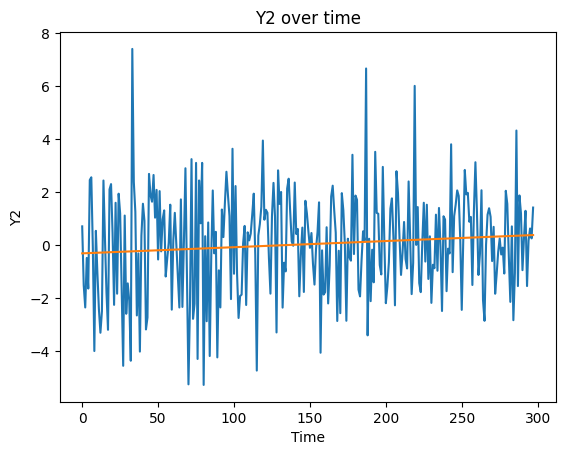

In [65]:
### Plotting the average daily value of y2 over the dataset. There is a slight increase but not substantial.

plt.plot(Y2_times, Y2_vals)
plt.plot(Y2_times, np.array(Y2_times) * slope_Y2 + intercept_Y2)
plt.xlabel('Time')
plt.ylabel('Y2')
plt.title("Y2 over time")
plt.show()

In [66]:
np.isnan(time_cutoff_dict_Y2[15]).sum()
#plt.plot(time_cutoff_dict_y2.keys(), time_cutoff_dict_y2.values())

0

In [69]:
# It is possible that splitting by time value during the day gives better results. This could be because certain trades execute in the morning 
# that were placed after-hours or traders execute more before they finish the data, etc. We loop through all hours and look at the difference in 
# average price 
for key_time in time_cutoff_dict_Y2.keys():
    print(key_time, np.mean(time_cutoff_dict_Y2[key_time]))

11 0.050228857
12 0.03051823
13 -0.1202506
14 0.08934679
15 0.174714
16 -0.04671645


In [70]:
from statsmodels.tsa.stattools import adfuller

result_adf_Y2 = adfuller(Y2_vals)
print(result_adf_Y2)

(-11.868839717667182, 6.57669025388587e-22, 2, 295, {'1%': -3.452713099849546, '5%': -2.871387839457783, '10%': -2.5720171933352485}, 1179.834959794601)


In [72]:
import pymannkendall as mk

result = mk.original_test(Y2_vals, alpha=0.05)
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.2690449518778377, z=1.1052646009537574, Tau=0.042957539601834904, s=1901.0, var_s=2955117.0, slope=0.0014943159543550932, intercept=-0.04906369974979988)


In [6]:
### If the time variable is at or before 12:00 PM, the afternoon variable is set to 0 else set to 1

data_y2_cleaned.loc[data_y2_cleaned['time'] > 43200000, 'afternoon'] = 1
data_y2_cleaned.loc[data_y2_cleaned['time'] <= 43200000, 'afternoon'] = 0

In [38]:
data_y2_cleaned.isna().any().any()

True

In [7]:
data_y2_cleaned['afternoon']

10         0.0
11         0.0
13         0.0
14         0.0
15         0.0
          ... 
6704607    1.0
6704608    1.0
6704609    1.0
6704612    1.0
6704613    1.0
Name: afternoon, Length: 6241196, dtype: float64

In [45]:
# Check for NaNs in each column
nan_columns = data_y2_cleaned.isna().any()

# Print columns that contain NaNs
print(nan_columns[nan_columns == True])

Series([], dtype: bool)


In [8]:
### Splitting into training, validation, test sets.
### The most recent data should be the test set, followed by the validation and the training in that order.
### I will use 01/2022 through the end of 09/2022 for train, 10/2022 through 12/2022 for val and 01/2023 through 03/2023 for test
### The split of train-val-test is about 60-20-20 which seems reasonable
import re

def parse_date_from_filename(filename):
    # Use regular expression to extract the date part
    match = re.search(r'(\d{4})(\d{2})(\d{2})', filename)
    if match:
        year, month, day = match.groups()
        return {
            'year': int(year),
            'month': int(month),
            'day': int(day)
        }
    else:
        return None



# Use the parse_date_from_filename function to extract date components
data_y2_cleaned['date_info'] = data_y2_cleaned['day'].apply(parse_date_from_filename)

# Convert the date_info into a datetime object for easy comparison
data_y2_cleaned['date'] = pd.to_datetime(data_y2_cleaned['date_info'].apply(lambda x: f"{x['year']}-{x['month']:02d}-{x['day']:02d}"))

# Define your date ranges
train_start, train_end = pd.to_datetime('2022-01-01'), pd.to_datetime('2022-09-30')
val_start, val_end = pd.to_datetime('2022-10-01'), pd.to_datetime('2022-12-31')
test_start, test_end = pd.to_datetime('2023-01-01'), pd.to_datetime('2023-03-31')

# Filter the DataFrame based on the date ranges
train_set = data_y2_cleaned[(data_y2_cleaned['date'] >= train_start) & (data_y2_cleaned['date'] <= train_end)]
val_set = data_y2_cleaned[(data_y2_cleaned['date'] >= val_start) & (data_y2_cleaned['date'] <= val_end)]
test_set = data_y2_cleaned[(data_y2_cleaned['date'] >= test_start) & (data_y2_cleaned['date'] <= test_end)]

# Output the results
print('Training Set:\n', train_set.shape, '\n')
print('Validation Set:\n', val_set.shape, '\n')
print('Test Set:\n', test_set.shape, '\n')
print('Full Set:\n', data_y2_cleaned.shape, '\n')


Training Set:
 (3767637, 386) 

Validation Set:
 (1249286, 386) 

Test Set:
 (1224273, 386) 

Full Set:
 (6241196, 386) 



In [47]:
3767637 + 1249286 + 1224273 == 6241196

True

In [10]:
plt.hist(train_set['y2'], bins=100)
plt.show()

plt.hist(train_set['Y2'], bins=100)
plt.show()

KeyError: 'y2'

In [51]:
train_set.columns

Index(['time', 'sym', 'exch', 'Q1', 'Q2', 'X1', 'X10', 'X100', 'X101', 'X102',
       ...
       'X96', 'X97', 'X98', 'X99', 'Y1', 'Y2', 'day', 'afternoon', 'date_info',
       'date'],
      dtype='object', length=386)

In [9]:
### Create X and y set for each of training, validation, test
columns_to_exclude = ['time', 'sym', 'exch', 'Q1', 'Q2', 'Y1', 'Y2', 'day', 'date_info', 'date']
X_train_y2 = train_set.drop(columns = columns_to_exclude)
y_train_y2 = train_set[['Y2']]

X_val_y2 = val_set.drop(columns = columns_to_exclude)
y_val_y2 = val_set[['Y2']]

X_test_y2 = test_set.drop(columns = columns_to_exclude)
y_test_y2 = test_set[['Y2']]

### Save these locally as .parquet files
save_dir = 'qr_takehome/Cleaned Data/Y2 Calibration/train_test_val'
X_train_y2.to_parquet(os.path.join(save_dir, 'X_train_y2.parquet'))
y_train_y2.to_parquet(os.path.join(save_dir, 'y_train_y2.parquet'))

X_val_y2.to_parquet(os.path.join(save_dir, 'X_val_y2.parquet'))
y_val_y2.to_parquet(os.path.join(save_dir, 'y_val_y2.parquet'))

X_test_y2.to_parquet(os.path.join(save_dir, 'X_test_y2.parquet'))
y_test_y2.to_parquet(os.path.join(save_dir, 'y_test_y2.parquet'))

In [3]:
### Loading the data in case of crashes 
import pandas as pd
import os

# Define the directory where the files are saved
save_dir = 'qr_takehome/Cleaned Data/Y2 Calibration/train_test_val'

# Load the .parquet files into their corresponding variables
X_train_y2 = pd.read_parquet(os.path.join(save_dir, 'X_train_y2.parquet'))
y_train_y2 = pd.read_parquet(os.path.join(save_dir, 'y_train_y2.parquet'))

X_val_y2 = pd.read_parquet(os.path.join(save_dir, 'X_val_y2.parquet'))
y_val_y2 = pd.read_parquet(os.path.join(save_dir, 'y_val_y2.parquet'))

X_test_y2 = pd.read_parquet(os.path.join(save_dir, 'X_test_y2.parquet'))
y_test_y2 = pd.read_parquet(os.path.join(save_dir, 'y_test_y2.parquet'))

# Print to confirm the files are loaded correctly
print('Data loaded successfully:')


Data loaded successfully:


In [4]:
import pandas as pd

# Assume X_train_y2 is your DataFrame

# Check for NaNs
contains_nan = X_train_y2.isna().any().any()

if contains_nan:
    print("X_train_y2 contains NaN values.")
else:
    print("X_train_y2 does not contain any NaN values.")

X_train_y2 does not contain any NaN values.


In [28]:
# Check for NaNs in each column
nan_columns = X_train_y2.isna().any()

# Print columns that contain NaNs
print(nan_columns[nan_columns == True])


afternoon    True
dtype: bool


In [30]:
import pandas as pd

# Assume X_train_y2 is your DataFrame

# Count the number of NaNs in the 'afternoon' column
nan_count_afternoon = X_train_y2['afternoon'].isna().sum()/X_train_y2.shape[0]

print(f"Number of NaN values in the 'afternoon' column: {nan_count_afternoon}")


Number of NaN values in the 'afternoon' column: 0.3580384734516621


In [16]:
### Calculating the correlation matrix for the training set
df = pd.concat([X_train_y1[X_train_y1['afternoon'] == 0], y_train_y1[X_train_y1['afternoon'] == 0]], axis=1)

In [5]:
df.shape

(3767637, 377)

In [25]:
temp = df[['X1', 'X2', 'X3']]

In [27]:
print(temp.shape)

(3767637, 3)


In [28]:
temp.corrwith(df['Y1'])

X1    0.009469
X2   -0.023580
X3   -0.010688
dtype: float64

In [17]:
correlations_with_y1 = df.corrwith(df['Y1'])

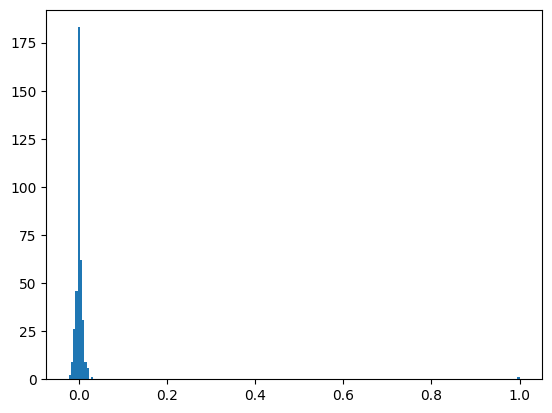

In [8]:
plt.hist(correlations_with_y1, bins=200)
plt.show()

In [18]:
# Sort the absolute correlations from greatest to smallest 
sorted_correlation = correlations_with_Y2.abs().sort_values(ascending=False)

# Print the sorted correlations
print(sorted_correlation[:11])

Y1     1.000000
X1     0.027883
X51    0.023336
X50    0.022899
X77    0.021257
X3     0.020154
X5     0.019694
X49    0.018790
X97    0.018777
X67    0.017806
X57    0.016641
dtype: float64


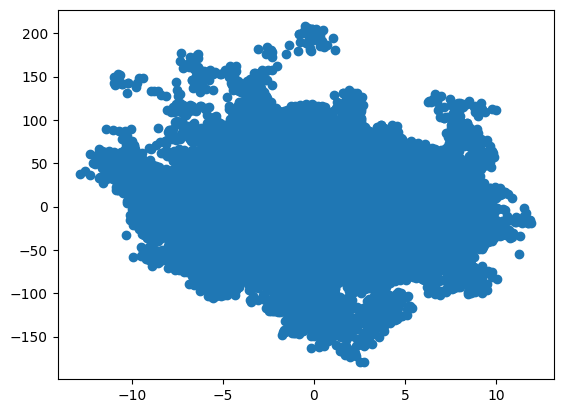

In [13]:
plt.scatter(X_train_y2['X375'], y_train_y2)
plt.show()

In [19]:
### Using the top ten variables with highest absolute correlation for linear regression + afternoon variable
top_vars = sorted_correlation[1:5].index.union(["afternoon"])
print(top_vars)

Index(['X1', 'X50', 'X51', 'X77', 'afternoon'], dtype='object')


In [44]:
X_train_y1[top_vars]

,X180,X181,X2,X206,X208,X209,X314,X375,X52,X53,afternoon
22500,5.330081,5.322297,0.074757,3.778755,5.096995,5.070271,6.328077,-1.368652,-1.151528,-0.937603,0
22501,3.655391,3.860835,-0.255630,2.179250,4.173613,4.149567,5.201862,-1.715522,-1.157537,-0.940948,0
22502,4.151245,4.139648,-0.024195,1.705772,4.208780,4.184245,5.313017,-1.557903,-1.158205,-0.941456,0
22503,1.951987,2.045184,0.170417,-0.208096,2.739458,2.718543,3.446875,-1.798359,-1.167342,-0.949278,0
22504,3.005407,2.991332,0.661844,1.216650,3.159348,3.137560,4.123048,-1.537982,-1.169131,-0.950971,0
...,...,...,...,...,...,...,...,...,...,...,...
6704607,1.174463,0.829295,1.449846,0.975366,0.302038,0.373109,0.508821,0.779830,0.254435,0.461328,1
6704608,2.431186,2.228773,1.029207,2.959800,1.839759,1.912024,1.983755,0.705589,0.261921,0.465597,1
6704609,2.403258,2.331252,0.830843,3.230067,2.376310,2.461990,2.198237,0.593758,0.262813,0.464662,1
6704612,1.664578,1.850044,1.033812,2.201009,1.731888,1.718102,1.415897,0.900047,0.263485,0.467586,1


In [6]:
# Initialize an empty list to store the names of columns with correlation less than 0.3
low_corr_columns = []

# Loop through each column in the DataFrame
for column in X_train_y1.columns:
    # Skip the comparison with itself
    if column != 'X174':
        # Calculate the correlation with 'X174'
        corr = X_train_y1[column].corr(X_train_y1['X174'])
        # Check if the correlation is less than 0.3
        if abs(corr) < 0.3:
            # If yes, append the column name to the list
            print(column)
            low_corr_columns.append(column)

print('Columns with correlation less than 0.3 to X174:', low_corr_columns)
#X_train_y1['X175'].corr(y_train_y1)

X1
X10
X100
X101
X102
X103
X104
X105
X106
X107
X108
X109
X11
X110
X111
X112
X113
X114
X115
X116
X117
X118
X12
X122
X123
X124
X125
X126
X127
X128
X129
X13
X130
X131
X132
X133
X134
X135
X136
X137
X138
X14
X142
X143
X144
X145
X146
X147
X148
X149
X15
X150
X151
X152
X153
X154
X155
X156
X157
X158
X159
X16
X160
X161
X162
X163
X164
X165
X17
X170
X171
X172
X173
X18
X182
X183
X184
X185
X186
X187
X188
X189
X19
X190
X191
X192
X193
X198
X199
X2
X20
X200
X201
X21
X210
X211
X212
X213
X214
X215
X216
X217
X218
X219
X22
X220
X221
X226
X227
X228
X229
X23
X230
X231
X232
X233
X234
X235
X236
X237
X238
X239
X24
X240
X241
X242
X243
X244
X245
X246
X247
X248
X249
X25
X250
X251
X252
X253
X254
X255
X256
X257
X258
X259
X26
X260
X261
X262
X263
X264
X265
X266
X267
X268
X269
X27
X270
X271
X272
X273
X274
X275
X276
X277
X278
X279
X28
X280
X281
X282
X283
X284
X285
X286
X287
X288
X289
X29
X290
X291
X292
X293
X294
X295
X296
X297
X298
X299
X3
X30
X300
X301
X302
X303
X304
X305
X306
X307
X308
X309
X31
X310
X311
X312
X315
X31

In [95]:
uncorrelated_fts = ['X1']
currCol = 'X1'
corr = ''
for column in X_train_y1.columns:
    corr = X_train_y1[column].corr(X_train_y1[currCol])
    # Check if the correlation is less than 0.3
    if abs(corr) < 0.3:
        # If yes, append the column name to the list
        print(column)
        uncorrelated_fts.append(column)
        currCol = column
if currCol not in uncorrelated_fts:
    uncorrelated_fts.append(currCol)

X10
X100
X11
X110
X114
X116
X118
X12
X120
X122
X126
X127
X13
X130
X138
X14
X140
X142
X143
X144
X146
X147
X148
X149
X15
X150
X151
X152
X153
X154
X155
X156
X157
X158
X16
X160
X166
X17
X170
X174
X18
X180
X182
X19
X190
X194
X2
X20
X200
X202
X21
X210
X22
X220
X222
X226
X229
X23
X230
X235
X238
X24
X240
X242
X25
X250
X254
X272
X276
X28
X280
X29
X290
X3
X30
X300
X31
X310
X313
X315
X316
X317
X32
X320
X33
X330
X335
X34
X340
X35
X350
X351
X36
X360
X37
X370
X371
X372
X374
X375
X38
X4
X40
X41
X42
X43
X44
X45
X46
X47
X48
X49
X5
X52
X54
X6
X60
X7
X70
X74
X8
X80
X84
X9
X90
afternoon


In [96]:
len(uncorrelated_fts)

127

In [14]:
#print(len(low_corr_columns))
#X_train_y1[uncorrelated_fts[0]].corr(X_train_y1[uncorrelated_fts[7]])
X_train_y2['X144'].corr(X_train_y2['X156'])

0.031104381670329896

In [16]:
from sklearn.feature_selection import mutual_info_regression

# Compute the mutual information
mi = mutual_info_regression(train_set[['Y1']], train_set[['Y2']])

# Make a Series for the results
mi_series = pd.Series(mi, index=train_set[['Y1']].columns)

print(mi_series)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y1    1.770231
dtype: float64


In [21]:
np.corrcoef(y_pred, y)[0][1]

0.9557915833664252

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extracting Y1 as the predictor and Y2 as the target
X = train_set[['Y1']]  # double brackets to keep it as a DataFrame
y = train_set['Y2']


# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

y_pred = model.predict(X)
mse = mean_squared_error(y_pred, y)
corry1y2 = np.corrcoef(y_pred, y)[0][1]
print('MSE is:', mse)
print('corr is:', corry1y2)



MSE is: 23.366007
corr is: 0.9557915833664252


In [107]:
### Get the correlation matrix with these 127 features

init_uncorr_feats = pd.Index(uncorrelated_fts)

corr_matrix = X_train_y1[init_uncorr_feats].corr().abs()

In [110]:
# Initialize a list to hold columns to drop
cols_to_drop = set()

# Iterate over the columns of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # If the absolute correlation value is high, add one of them to the set of columns to drop
        if corr_matrix.iloc[i, j] >= 0.3 and corr_matrix.columns[j] not in cols_to_drop:
            colname = corr_matrix.columns[i]  # getting the name of the column
            cols_to_drop.add(colname)

# Now cols_to_drop contains the names of columns to drop
# Drop the highly correlated columns
final_unc_fts = X_train_y1[uncorrelated_fts].drop(columns=cols_to_drop).columns

print(f"Uncorrelated columns: {final_unc_fts}")

Uncorrelated columns: Index(['X1', 'X10', 'X110', 'X114', 'X116', 'X118', 'X12', 'X127', 'X142',
       'X143', 'X146', 'X147', 'X166', 'X20', 'X254', 'X335', 'X372', 'X40',
       'X44', 'X45', 'X49', 'X74', 'afternoon'],
      dtype='object')


In [9]:
final_unc_fts = ['X1', 'X10', 'X110', 'X114', 'X116', 'X118', 'X12', 'X127', 'X142',
       'X143', 'X146', 'X147', 'X166', 'X20', 'X254', 'X335', 'X372', 'X40',
       'X44', 'X45', 'X49', 'X74', 'afternoon']

In [67]:
### Getting 20 features with highest mutual information with Y1. 

from sklearn.feature_selection import mutual_info_regression

for col in final_unc_fts:

    # Compute the mutual information
    mi = mutual_info_regression(X_train_y1[[col]], y_train_y1)

    # Make a Series for the results
    mi_series = pd.Series(mi, index=X_train_y1[[col]].columns)

    print(col, mi_series)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X1 X1    0.018423
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X10 X10    0.028155
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X110 X110    0.018046
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X114 X114    0.073591
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X116 X116    0.077575
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X118 X118    0.110019
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X12 X12    0.012434
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X127 X127    0.069064
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X142 X142    0.927242
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X143 X143    4.498024
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X146 X146    0.225316
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X147 X147    1.927353
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X166 X166    0.017658
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X20 X20    0.00383
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X254 X254    0.072644
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X335 X335    0.071008
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X372 X372    0.073079
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X40 X40    0.075312
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X44 X44    0.096382
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X45 X45    0.178705
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X49 X49    0.066325
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X74 X74    0.028908
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


afternoon afternoon    0.201349
dtype: float64


In [100]:
top_var_features = sorted_variances.head(5).index
top_var_features

Index(['X202', 'X203', 'X174', 'X175', 'X204'], dtype='object')

In [10]:
final_unc_fts = ['X1', 'X10', 'X110', 'X114', 'X116', 'X118', 'X12', 'X127', 'X142',
       'X143', 'X146', 'X147', 'X166', 'X20', 'X254', 'X335', 'X372', 'X40',
       'X44', 'X45', 'X49', 'X74', 'afternoon']

In [11]:
### Combining features with high variance and high correlation 
#top_tot_features = top_vars
top_tot_features = pd.Index(final_unc_fts)

In [12]:
### Lasso feature selection for the morning 

from sklearn.linear_model import Lasso

# Initialize the Lasso model
# alpha controls the amount of shrinkage: larger values specify stronger regularization
lasso = Lasso(alpha=.01)  # Adjust alpha based on your dataset

# Fit the model
lasso.fit(X_train_y2[top_tot_features], y_train_y2)


Lasso(alpha=0.01)

In [13]:
# Get the coefficients
coefficients = lasso.coef_

# Optionally, create a boolean mask for selected features (non-zero coefficients)
selected_features_mask = coefficients != 0

# Print out the names of the selected features
# Print out the names of the selected features


lass_feats_y2 = X_train_y2[top_tot_features].columns[selected_features_mask].union(['afternoon'])
print(lass_feats_y2)

Index(['X1', 'X10', 'X110', 'X114', 'X116', 'X118', 'X20', 'X335', 'X372',
       'X44', 'X74', 'afternoon'],
      dtype='object')


In [29]:
#lass_feats_y1 = pd.Index(['X1', 'X10', 'X114', 'X116', 'X118', 'X143', 'X147', 'X372', 'X44', 'afternoon'], dtype='object') 
#lass_feats_y1 = pd.Index(['X118', 'X143', 'X147', 'X44', 'afternoon'], dtype='object') 
lass_feats_y1 = pd.Index(['X1', 'X10', 'X110', 'X114', 'X116', 'X118', 'X20', 'X335', 'X372',
       'X44', 'X74', 'afternoon'],
      dtype='object')

In [30]:
top_tot_features = lass_feats_y1

In [31]:
### Creating initial linear regression model using these variables
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a Linear Regression model
model = LinearRegression()

# Fit (train) the model on your data
#model.fit(X_train_y1[top_vars], y_train_y1)
model.fit(X_train_y2[top_tot_features], y_train_y2)
# Get the training and validation predictions to get MSE
y_train_pred_y2 = model.predict(X_train_y2[top_tot_features])
y_val_pred_y2 = model.predict(X_val_y2[top_tot_features])

mse_train_y2 = mean_squared_error(y_train_y2, y_train_pred_y2)
mse_val_y2 = mean_squared_error(y_val_y2, y_val_pred_y2)

print(mse_train_y2, mse_val_y2)


269.9602118706956 225.72653941010967


In [22]:
### Performing RFE with linear model and these features
from sklearn.feature_selection import RFE

# Initialize a linear regression model
linear_model = LinearRegression()

# Initialize RFE with the linear model and desired number of features
num_features_to_select = 10  # for example, choose 10 features
rfe = RFE(estimator=linear_model, n_features_to_select=num_features_to_select)

rfe.fit(X_train_y2[top_tot_features], y_train_y2)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [23]:
# Get the ranking of the features. 
# Features with ranking 1 are selected by RFE
ranking = rfe.ranking_

# Get the mask of selected features (features with rank 1 are selected)
selected_features_mask = rfe.support_

# Get the selected feature names if you're using a pandas DataFrame
if isinstance(X_train_y2, pd.DataFrame):
    selected_feature_names = X_train_y2[top_tot_features].columns[selected_features_mask]
    print("Selected features:", selected_feature_names)

# Print the ranking
print("Feature ranking:", ranking)

Selected features: Index(['X118', 'X20', 'X335', 'X372', 'X44', 'X74', 'afternoon'], dtype='object')
Feature ranking: [1 1 1 1 1 1 1]


In [26]:
top_tot_features = selected_feature_names

In [33]:
for coeff,name in zip(coefficients.reshape(-1).tolist(), feature_names.to_list()):
    print(coeff,name)

0.1568341314837869 X1
-0.037324892051129425 X10
0.11098108743690752 X114
0.09553339455383426 X116
-0.015637364884467157 X118
0.1375949409034615 X143
0.15323034278719955 X147
-0.05874139139016094 X372
-0.151608163335215 X44
0.025911287285092403 afternoon


In [33]:
# Get the coefficients and the intercept
coefficients = model.coef_
intercept = model.intercept_

# Get feature names if X_train is a DataFrame, otherwise use a generic naming scheme
if isinstance(X_train_y2, pd.DataFrame):
    feature_names = X_train_y2[top_tot_features].columns
else:
    feature_names = [f'x{i}' for i in range(1, len(coefficients) + 1)]
feature_names
# Construct equation components
equation_terms = [f"{coeff}*{name}" for coeff,name in zip(coefficients.reshape(-1).tolist(), feature_names.to_list())]

# Combine terms and add intercept
equation = " + ".join(equation_terms) + f" + {intercept}"

print("Linear Model Equation:")
print("Y1 = ", equation)

Linear Model Equation:
Y1 =  0.4449436772263295*X1 + 0.06006251850779655*X10 + 0.07903327626190287*X110 + 0.160591162622354*X114 + 0.10806743486272212*X116 + -0.048542652223079526*X118 + 0.6347399136750168*X20 + -0.4108515271210851*X335 + -0.11927884632174064*X372 + -0.35644407503369435*X44 + -0.06072720349867292*X74 + 0.13130361914398447*afternoon + [-0.23209854]


In [20]:
### Testing with mean method 
mean_y = np.mean(y_train_y2)
y_val_pred_y2 = [mean_y]*len(y_val_y2)
mse_val_y2 = mean_squared_error(y_val_y2, y_val_pred_y2)
print(mse_val_y2)

225.73032


In [22]:
y_val_y2 = y_val_y2.to_numpy().reshape(-1)

In [32]:
# Calculate the signs of the true values and the predicted values
sign_true = np.sign(y_val_y2)
sign_pred = np.sign(y_val_pred_y2)

# Calculate the fraction of instances where the signs are the same
fraction_same_sign = np.mean(sign_true == sign_pred)

print('Fraction of instances where predicted values have the same sign as the true values:', fraction_same_sign)

Fraction of instances where predicted values have the same sign as the true values: 0.5060082319020625


In [73]:
from sklearn.linear_model import Lasso

# Initialize the Lasso model
lasso = Lasso(alpha=.003)  # You can adjust alpha as needed

# Fit the model
lasso.fit(X_train_y1[top_tot_features], y_train_y1)

y_train_pred_y1 = lasso.predict(X_train_y1[top_tot_features])
y_val_pred_y1 = lasso.predict(X_val_y1[top_tot_features])

mse_train_y1 = mean_squared_error(y_train_y1, y_train_pred_y1)
mse_val_y1 = mean_squared_error(y_val_y1, y_val_pred_y1)

print(mse_train_y1, mse_val_y1)

155.0328065417388 137.09765795828466


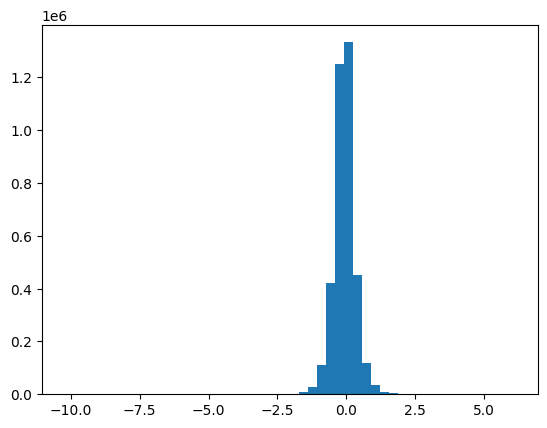

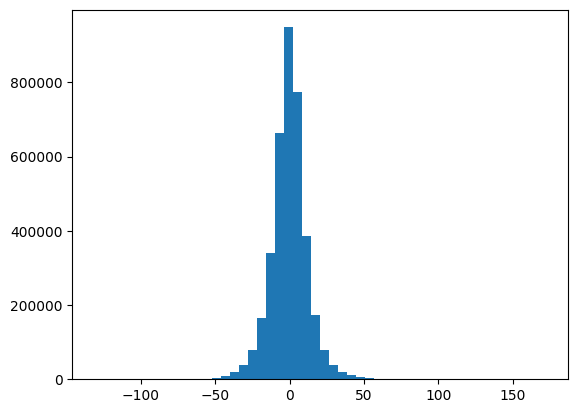

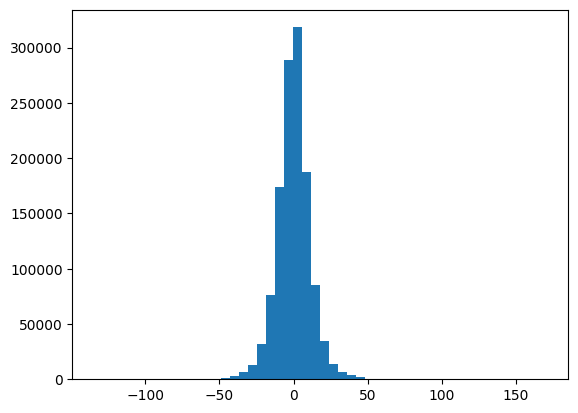

In [66]:
plt.hist(y_train_pred_y1, bins=50)
plt.show()

plt.hist(y_train_y1, bins=50)
plt.show()

plt.hist(y_val_y1, bins=50)
plt.show()

In [11]:
### Using LASSO for feature selection 

# normalize features first
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_y1_scaled = scaler.fit_transform(X_train_y1[top_vars])

from sklearn.linear_model import Lasso

# Initialize Lasso model
lasso = Lasso(alpha=0.01) 

# Fit the model
lasso.fit(X_train_y1_scaled, y_train_y1)

Lasso(alpha=0.01)

In [15]:
# Convert the scaled data back to a DataFrame
X_train_y1_scaled = pd.DataFrame(X_train_y1_scaled, columns=X_train_y1[top_vars].columns, index=X_train_y1[top_vars].index)

In [17]:
# Get the coefficients
lasso_coef = lasso.coef_

# Look at the variables with non-zero coefficients
selected_features = X_train_y1_scaled.columns[(lasso_coef != 0)].tolist()
print("Selected features:", selected_features)
print(len(selected_features))


Selected features: ['X116', 'X122', 'X123', 'X124', 'X169', 'X18', 'X19', 'X197', 'X198', 'X2', 'X201', 'X206', 'X222', 'X223', 'X234', 'X273', 'X274', 'X275', 'X372', 'X373', 'X375', 'X46', 'X52', 'X76', 'afternoon']
25


In [97]:
# Train new model using these features 

# Create a Linear Regression model
model = LinearRegression()

# Fit (train) the model on your data
model.fit(X_train_y1_scaled[selected_features], y_train_y1)

# Get scaled version of the validation set
X_val_y1_scaled = scaler.fit_transform(X_val_y1[top_vars])
X_val_y1_scaled = pd.DataFrame(X_val_y1_scaled, columns=X_val_y1[top_vars].columns, index=X_val_y1[top_vars].index)

# Get the training and validation predictions to get MSE
y_train_pred_y1 = model.predict(X_train_y1_scaled[selected_features])
y_val_pred_y1 = model.predict(X_val_y1_scaled[selected_features])

mse_train_y1 = mean_squared_error(y_train_y1, y_train_pred_y1)
mse_val_y1 = mean_squared_error(y_val_y1, y_val_pred_y1)

print(mse_train_y1, mse_val_y1)

NameError: name 'X_train_y1_scaled' is not defined

In [40]:
mse_val_y1

137.33581043473657

In [41]:
# Using sequential feature selection to get at most 10 variables 
from sklearn.feature_selection import SequentialFeatureSelector as SFS

model = LinearRegression()
sfs = SFS(model, n_features_to_select=10, direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs = sfs.fit(X_train_y1_scaled[selected_features], y_train_y1)


AttributeError: 'SequentialFeatureSelector' object has no attribute 'k_feature_idx_'

In [46]:
sfs_feats = sfs.get_feature_names_out()

In [48]:
X_train_sfs_y1 = X_train_y1_scaled[sfs_feats]
X_train_sfs_y1.shape

(3767637, 10)

In [49]:
# Train another linear regression model

# Create a Linear Regression model
model = LinearRegression()

# Fit (train) the model on your data
model.fit(X_train_y1_scaled[sfs_feats], y_train_y1)

# Get the training and validation predictions to get MSE
y_train_pred_y1 = model.predict(X_train_y1_scaled[sfs_feats])
y_val_pred_y1 = model.predict(X_val_y1_scaled[sfs_feats])

mse_train_y1 = mean_squared_error(y_train_y1, y_train_pred_y1)
mse_val_y1 = mean_squared_error(y_val_y1, y_val_pred_y1)

print(mse_train_y1, mse_val_y1)

154.92409611158428 137.14619708450968


In [114]:
### Training an initial xgboost model since the linear model does not seem to improve

import xgboost as xgb

# Initialize the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.01, max_depth=2, random_state=42)

# Fit the model
xgb_model.fit(X_train_y1[top_tot_features], y_train_y1)

# Optionally, you can evaluate the model on validation data (X_val, y_val)
# xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [144]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Sort the feature importances in descending order and select top N features
sorted_idx = feature_importances.argsort()[::-1][:10]

# Get the names of the top features
top_features = X_train_y1.columns[sorted_idx]
top_features = top_features.append(pd.Index(['afternoon']))

In [9]:
# Using only select rows 

X__train_select_y1 = X_train_y1
y_train_select_y1 = y_train_y1

In [10]:
X__train_select_y1.shape

(3767637, 376)

In [11]:
# Retrain with just these features 

# Initialize the model
xgb_model_top = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.003, max_depth=3, random_state=42)

# Fit the model
xgb_model_top.fit(X__train_select_y1[top_tot_features], y_train_select_y1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.003, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [17]:
# Make the training and validation labels have shape (n,)

y_train_y1 = y_train_y1.to_numpy()
y_val_y1 = y_val_y1.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [16]:
print(y_val_y1.shape)
print(y_val_pred_y1.shape)

(1249286, 1)
(1249286,)


In [13]:
# Evaluate this on the training and validation data

y_train_pred_y1 = xgb_model_top.predict(X_train_y1[top_tot_features])
y_val_pred_y1 = xgb_model_top.predict(X_val_y1[top_tot_features])

mse_train_y1 = mean_squared_error(y_train_y1, y_train_pred_y1)
mse_val_y1 = mean_squared_error(y_val_y1, y_val_pred_y1)

print(mse_train_y1, mse_val_y1)

from sklearn.metrics import mean_absolute_error

mae_train_y1 = mean_absolute_error(y_train_pred_y1, y_train_y1)
mae_val_y1 = mean_absolute_error(y_val_pred_y1, y_val_y1)

print(mae_train_y1, mae_val_y1)

155.24664 137.11363
8.977689 8.411222


In [124]:
# Creating y_val_select_y1 which contains strange events in the validation set 
y_val_select_y1 = y_val_y1[(y_val_y1 < -24) | (y_val_y1 > 24)]

In [18]:
# For Mean Prediction Benchmark

mean_y = np.mean(y_train_select_y1)
mse_baseline = mean_squared_error(y_val_y1, [mean_y]*len(y_val_y1))
print('MSE of mean prediction:', mse_baseline)

mae_baseline = mean_absolute_error([mean_y]*len(y_val_y1), y_val_y1)
print('MAE of mean prediction:', mae_baseline)

MSE of mean prediction: 137.09378
MAE of mean prediction: 8.408851


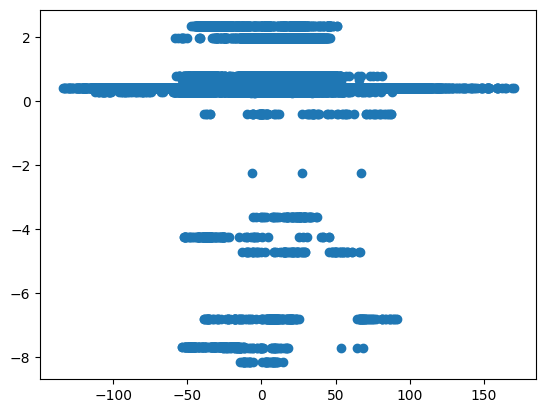

In [19]:
plt.scatter(y_val_y1, y_val_pred_y1)
plt.show()

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(len(top_tot_features), activation='relu', input_shape=(10,)))

# Add one hidden layer 
model.add(Dense(10, activation='relu'))

# Add an output layer 
model.add(Dense(1, activation='linear'))


In [109]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

model.fit(X_train_y1[X_train_y1['afternoon'] == 1][top_tot_features], y_train_y1[X_train_y1['afternoon'] == 1], epochs=4, batch_size=64, verbose=1)

Epoch 1/4
37792/37792 [==============================] - 38s 977us/step - loss: 140.6033 - mse: 140.6033
Epoch 2/4
37792/37792 [==============================] - 37s 979us/step - loss: 139.4686 - mse: 139.4686
Epoch 3/4
37792/37792 [==============================] - 36s 956us/step - loss: 139.0039 - mse: 139.0039
Epoch 4/4
37792/37792 [==============================] - 36s 964us/step - loss: 138.7310 - mse: 138.7310


In [110]:
model.evaluate(X_val_y1[X_val_y1['afternoon'] == 1][top_tot_features], y_val_y1[X_val_y1['afternoon'] == 1], verbose=1)


25104/25104 [==============================] - 20s 782us/step - loss: 122.0439 - mse: 122.0439


[122.04387664794922, 122.04387664794922]

In [89]:
# Looking at histogram of 

pd.Series(y_train_y1.reshape(-1)).describe()

count    3.767637e+06
mean    -7.069199e-02
std      1.245354e+01
min     -1.308300e+02
25%     -6.615149e+00
50%      0.000000e+00
75%      6.480218e+00
max      1.721492e+02
dtype: float64